In [1]:
# importing the packages
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import date
import sklearn.exceptions
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest
from imblearn.under_sampling import NearMiss 
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)


from numpy import asarray
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [2]:
data_train = pd.read_csv("fraudTrain.csv")
data_test = pd.read_csv("fraudTest.csv")
# taking smaller sample to run the model faster

df_train= data_train.sample(frac = 0.1,random_state=1)
df_test= data_test.sample(frac = 0.05,random_state=1)
print(df_train.shape,df_test.shape)

(129668, 23) (27786, 23)


In [3]:
def getdatafiles():
    # loading data
    data_train = pd.read_csv("fraudTrain.csv")
    data_test = pd.read_csv("fraudTest.csv")
    # taking smaller sample to run the model faster

    df_train= data_train.sample(frac = 0.1,random_state=1)
    df_test= data_test.sample(frac = 0.05,random_state=1)
    print(df_train.shape,df_test.shape)
    
    # function to drop tbe columns
    def dropCol(data):
        col_to_drop = ['trans_date_trans_time','Unnamed: 0',
                       'cc_num','first','last','trans_num','street',
                      'trans_date_trans_time','unix_time']
        res = data.drop(col_to_drop,axis = 1)
        return res
    # dropping the columns
    # dropping the columns ['trans_date_trans_time','Unnamed: 0','cc_num','first','last','trans_num']
    # train data set
    df_train = dropCol(df_train)
    # test data set
    df_test = dropCol(df_test)
    
    # creating a new feature address
    df_train['add'] = df_train['city'] + df_train['state'] + df_train['zip'].astype(str)
    df_test['add'] = df_test['city'] + df_test['state'] + df_test['zip'].astype(str)
    df_train = df_train.drop(['city','state','zip'],axis =1)
    df_test = df_test.drop(['city','state','zip'],axis =1)
    print ( df_train.shape, df_test.shape)
    

    #Create independent and Dependent Features
    columns = df_train.columns.tolist()

    # removing the dependent feature is_fraud
    columns = [c for c in columns if c not in ["is_fraud"]]

    X_train = df_train[columns]
    Y_train = df_train['is_fraud']
    X_test = df_test[columns]
    Y_test = df_test['is_fraud']
    print ( X_train.shape, Y_train.shape,X_test.shape, Y_test.shape)

    # function to convert dob to years
    def age_years(born):
        return 2019 - int(born[0:4])

    # replacing the dob column with age column in our data set for test and train
    X_train['age'] = X_train['dob'].apply(lambda x: age_years(x))
    X_train = X_train.drop(['dob'],axis =1)

    X_test['age'] = X_test['dob'].apply(lambda x: age_years(x))
    X_test = X_test.drop(['dob'],axis =1)
    
    print(X_train.shape,X_test.shape)

    # concanating the test and train data so that number of columns remain the same in both the data sets
    final_df = pd.concat([X_train,X_test],axis=0)
    final_df.shape


    # creating the list of categorical variables
    categorical_features =[feature for feature in X_train.columns if final_df[feature].dtypes == 'O']
    categorical_features
    
    # function to convert categorical variables to one hot encoding
    def category_onehot_multcols(data,multcolumns):
        df_final = data
        i=0
        for fields in multcolumns:
            print(fields)
            df1=pd.get_dummies(final_df[fields],drop_first=True)
            final_df.drop([fields],axis=1,inplace=True)
            if i==0:
                df_final=df1.copy()
            else:           
                df_final=pd.concat([df_final,df1],axis=1)
            i=i+1             
        df_final=pd.concat([final_df,df_final],axis=1)
        return df_final

    # applying the one hot encoding
    final_df = category_onehot_multcols(final_df, categorical_features)

    # removing duplicated columns
    final_df =final_df.loc[:,~final_df.columns.duplicated()]
    final_df.shape

    # separating the test and training data
    df_Train=final_df.iloc[:129668,:]
    df_Test=final_df.iloc[129668:,:]
    print(df_Train.shape,df_Test.shape)
    print(Y_train.value_counts(),"\n",Y_test.value_counts())
    
    # define standard scaler
    scaler = StandardScaler()
    # transform data
    df_Train = scaler.fit_transform(df_Train)
    df_Test = scaler.fit_transform(df_Test)# define standard scaler
    
    
    
    # files ready for testing on models
    print(df_Train.shape, df_Test.shape, Y_train.shape, Y_test.shape)
    return df_Train, df_Test, Y_train, Y_test


In [4]:
# function to evaluate our model 
def print_eval(y_pred,model):
    print("Training Accuracy: ",model.score(df_Train, Y_train))
    print("Testing Accuracy: ", model.score(df_Test, Y_test))
    print(confusion_matrix(Y_test, y_pred))
    
    print(classification_report(Y_test,y_pred))


In [5]:
df_Train, df_Test, Y_train, Y_test = getdatafiles()

(129668, 23) (27786, 23)
(129668, 13) (27786, 13)
(129668, 12) (129668,) (27786, 12) (27786,)
(129668, 12) (27786, 12)
merchant
category
gender
job
add
(129668, 2143) (27786, 2143)
0    128963
1       705
Name: is_fraud, dtype: int64 
 0    27656
1      130
Name: is_fraud, dtype: int64
(129668, 2143) (27786, 2143) (129668,) (27786,)


   
### 5.  Considering the Fraud cases as anamoly and use anamoly detection methods such as:   
> 5.1 Simple Statistical Methods : Metrics such as distribution, including mean, median, mode, and quantiles could be used to identify outliers since the definition of an anomalous data point is one that deviates by a certain standard deviation from the mean.    
5.2 Density-Based Anomaly Detection : These include the    
 - 5.2.1 k-nearest neighbors algorithm   
 - 5.2.2 Relative density of data based method known as local outlier factor (LOF) algorithm **(Implemented)** 
 
>5.3 Isolation Forest **(Implemented)**   
5.4 Clustering-Based Anomaly Detection : K-means algorithm  **(Implemented)**
5.5 Support Vector Machine-Based Anomaly Detection          
5.6 Using Auto Encoders **(Implemented)**       
5.7 Neural Network  (Same as Autoencoders? ???)  
5.8 OneClassSVM    
5.9 DBSCAN    

## 5.6 Implementing Autoencoder to detect the fraud cases


#### Acknowledgemet:
https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd (Venelin Vankov)    
https://github.com/curiousily/Credit-Card-Fraud-Detection-using-Autoencoders-in-Keras/blob/master/fraud_detection.ipynb    

https://www.youtube.com/watch?v=S31E-ftRfQI    

https://github.com/dpanagop/ML_and_AI_examples/blob/master/Credit_Fraud_detection_with_autoencoders.ipynb  (not used)   
https://www.youtube.com/watch?v=S31E-ftRfQI  (refernce)  

       

Neural Networks has many hyperparameters, including:   
- number of hidden layers   
- number of neurons   
- learning rate   
- activation function   
- and optimizer settings

In [6]:
df_Train.shape,df_Test.shape

((129668, 2143), (27786, 2143))

#### Base model with 4 fully connected layers
This Autoencoder uses 4 fully connected layers with 14, 7, 7 and 29 neurons respectively.   
The first two layers are used for our encoder, the last two go for the decoder.   
Additionally, L1 regularization will be used during training

In [7]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [12]:
# building the model
input_dim = df_Train.shape[1]

encoding_dim = 14

input_layer = Input(shape=(input_dim, ))
layer1 = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer) # encoder
layer2 = Dense(int(encoding_dim / 2), activation="relu")(layer1)          # encode
layer3 = Dense(int(encoding_dim / 2), activation='tanh')(layer2)          # decoder
layer4 = Dense(input_dim, activation='relu')(layer3)                      # decoder
autoencoder = Model(inputs=input_layer, outputs=layer4)

In [11]:
layer1,layer2,layer3,layer4,autoencoder


(<tf.Tensor 'dense/Tanh:0' shape=(None, 14) dtype=float32>,
 <tf.Tensor 'dense_1/Relu:0' shape=(None, 7) dtype=float32>,
 <tf.Tensor 'dense_2/Tanh:0' shape=(None, 7) dtype=float32>,
 <tf.Tensor 'dense_3/Relu:0' shape=(None, 2143) dtype=float32>,
 <tensorflow.python.keras.engine.functional.Functional at 0x7fb878317f90>)

In [13]:
layer1,layer2,layer3,layer4,autoencoder

(<tf.Tensor 'dense_4/Tanh:0' shape=(None, 14) dtype=float32>,
 <tf.Tensor 'dense_5/Relu:0' shape=(None, 7) dtype=float32>,
 <tf.Tensor 'dense_6/Tanh:0' shape=(None, 7) dtype=float32>,
 <tf.Tensor 'dense_7/Relu:0' shape=(None, 2143) dtype=float32>,
 <tensorflow.python.keras.engine.functional.Functional at 0x7fb87851a810>)

In [15]:
#training the model
%%time
nb_epoch = 1000
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    #loss='mean_squared_error', 
                    loss = 'binary_crossentropy',
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(df_Train, df_Train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(df_Test, df_Test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/1000
   1/4053 [..............................] - ETA: 0s - loss: 0.0097 - accuracy: 0.0000e+00WARNING:tensorflow:From /Users/sapnasharma/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
4053/4053 [==============================] - 15s 4ms/step - loss: -0.0396 - accuracy: 0.0021 - val_loss: -0.0466 - val_accuracy: 0.0014
Epoch 2/1000
4053/4053 [==============================] - 15s 4ms/step - loss: -0.0498 - accuracy: 0.0020 - val_loss: -0.0526 - val_accuracy: 0.0019
Epoch 3/1000
4053/4053 [==============================] - 13s 3ms/step - loss: -0.0573 - accuracy: 0.0024 - val_loss: -0.0630 - val_accuracy: 0.0026
Epoch 4/1000
4053/4053 [==============================] - 10s 2ms/step - loss: -0.0672 - accuracy: 0.0052 - val_loss: -0.0699 - val_accuracy: 0.0091
Epoch 5/1000
4053

4053/4053 [==============================] - 9s 2ms/step - loss: -0.1114 - accuracy: 0.0203 - val_loss: -0.1096 - val_accuracy: 0.0236
Epoch 107/1000
4053/4053 [==============================] - 9s 2ms/step - loss: -0.1116 - accuracy: 0.0208 - val_loss: -0.1078 - val_accuracy: 0.0227
Epoch 108/1000
4053/4053 [==============================] - 9s 2ms/step - loss: -0.1117 - accuracy: 0.0202 - val_loss: -0.1087 - val_accuracy: 0.0218
Epoch 109/1000
4053/4053 [==============================] - 9s 2ms/step - loss: -0.1114 - accuracy: 0.0201 - val_loss: -0.1086 - val_accuracy: 0.0217
Epoch 110/1000
4053/4053 [==============================] - 9s 2ms/step - loss: -0.1116 - accuracy: 0.0188 - val_loss: -0.1090 - val_accuracy: 0.0190
Epoch 111/1000
4053/4053 [==============================] - 9s 2ms/step - loss: -0.1116 - accuracy: 0.0197 - val_loss: -0.1078 - val_accuracy: 0.0234
Epoch 112/1000
4053/4053 [==============================] - 8s 2ms/step - loss: -0.1113 - accuracy: 0.0186 - val_lo

Epoch 215/1000
4053/4053 [==============================] - 9s 2ms/step - loss: -0.1120 - accuracy: 0.0139 - val_loss: -0.1084 - val_accuracy: 0.0167
Epoch 216/1000
4053/4053 [==============================] - 9s 2ms/step - loss: -0.1122 - accuracy: 0.0144 - val_loss: -0.1086 - val_accuracy: 0.0150
Epoch 217/1000
4053/4053 [==============================] - 8s 2ms/step - loss: -0.1124 - accuracy: 0.0140 - val_loss: -0.1093 - val_accuracy: 0.0149
Epoch 218/1000
4053/4053 [==============================] - 8s 2ms/step - loss: -0.1126 - accuracy: 0.0142 - val_loss: -0.1078 - val_accuracy: 0.0153
Epoch 219/1000
4053/4053 [==============================] - 8s 2ms/step - loss: -0.1123 - accuracy: 0.0141 - val_loss: -0.1080 - val_accuracy: 0.0145
Epoch 220/1000
4053/4053 [==============================] - 9s 2ms/step - loss: -0.1125 - accuracy: 0.0135 - val_loss: -0.1087 - val_accuracy: 0.0148
Epoch 221/1000
4053/4053 [==============================] - 8s 2ms/step - loss: -0.1127 - accuracy: 

4053/4053 [==============================] - 8s 2ms/step - loss: -0.1124 - accuracy: 0.0111 - val_loss: -0.1084 - val_accuracy: 0.0135
Epoch 324/1000
4053/4053 [==============================] - 8s 2ms/step - loss: -0.1115 - accuracy: 0.0111 - val_loss: -0.1046 - val_accuracy: 0.0112
Epoch 325/1000
4053/4053 [==============================] - 9s 2ms/step - loss: -0.1116 - accuracy: 0.0130 - val_loss: -0.1088 - val_accuracy: 0.0135
Epoch 326/1000
4053/4053 [==============================] - 8s 2ms/step - loss: -0.1122 - accuracy: 0.0122 - val_loss: -0.1083 - val_accuracy: 0.0125
Epoch 327/1000
4053/4053 [==============================] - 9s 2ms/step - loss: -0.1122 - accuracy: 0.0130 - val_loss: -0.1083 - val_accuracy: 0.0141
Epoch 328/1000
4053/4053 [==============================] - 8s 2ms/step - loss: -0.1124 - accuracy: 0.0124 - val_loss: -0.1078 - val_accuracy: 0.0137
Epoch 329/1000
4053/4053 [==============================] - 9s 2ms/step - loss: -0.1120 - accuracy: 0.0125 - val_lo

Epoch 432/1000
4053/4053 [==============================] - 8s 2ms/step - loss: -0.1126 - accuracy: 0.0122 - val_loss: -0.1080 - val_accuracy: 0.0137
Epoch 433/1000
4053/4053 [==============================] - 9s 2ms/step - loss: -0.1123 - accuracy: 0.0120 - val_loss: -0.1064 - val_accuracy: 0.0132
Epoch 434/1000
4053/4053 [==============================] - 8s 2ms/step - loss: -0.1120 - accuracy: 0.0124 - val_loss: -0.1080 - val_accuracy: 0.0132
Epoch 435/1000
4053/4053 [==============================] - 8s 2ms/step - loss: -0.1125 - accuracy: 0.0114 - val_loss: -0.1074 - val_accuracy: 0.0108
Epoch 436/1000
4053/4053 [==============================] - 9s 2ms/step - loss: -0.1121 - accuracy: 0.0123 - val_loss: -0.1075 - val_accuracy: 0.0135
Epoch 437/1000
4053/4053 [==============================] - 8s 2ms/step - loss: -0.1120 - accuracy: 0.0131 - val_loss: -0.1083 - val_accuracy: 0.0161
Epoch 438/1000
4053/4053 [==============================] - 9s 2ms/step - loss: -0.1123 - accuracy: 

4053/4053 [==============================] - 8s 2ms/step - loss: -0.1122 - accuracy: 0.0139 - val_loss: -0.1065 - val_accuracy: 0.0139
Epoch 541/1000
4053/4053 [==============================] - 8s 2ms/step - loss: -0.1129 - accuracy: 0.0143 - val_loss: -0.1080 - val_accuracy: 0.0156
Epoch 542/1000
4053/4053 [==============================] - 8s 2ms/step - loss: -0.1129 - accuracy: 0.0129 - val_loss: -0.1070 - val_accuracy: 0.0135
Epoch 543/1000
4053/4053 [==============================] - 8s 2ms/step - loss: -0.1125 - accuracy: 0.0126 - val_loss: -0.1077 - val_accuracy: 0.0150
Epoch 544/1000
4053/4053 [==============================] - 8s 2ms/step - loss: -0.1120 - accuracy: 0.0128 - val_loss: -0.1070 - val_accuracy: 0.0128
Epoch 545/1000
4053/4053 [==============================] - 8s 2ms/step - loss: -0.1123 - accuracy: 0.0114 - val_loss: -0.1063 - val_accuracy: 0.0099
Epoch 546/1000
4053/4053 [==============================] - 8s 2ms/step - loss: -0.1124 - accuracy: 0.0098 - val_lo

4053/4053 [==============================] - 10s 2ms/step - loss: -0.1116 - accuracy: 0.0133 - val_loss: -0.1054 - val_accuracy: 0.0142
Epoch 649/1000
4053/4053 [==============================] - 9s 2ms/step - loss: -0.1117 - accuracy: 0.0134 - val_loss: -0.1062 - val_accuracy: 0.0142
Epoch 650/1000
4053/4053 [==============================] - 9s 2ms/step - loss: -0.1119 - accuracy: 0.0132 - val_loss: -0.1068 - val_accuracy: 0.0148
Epoch 651/1000
4053/4053 [==============================] - 9s 2ms/step - loss: -0.1114 - accuracy: 0.0136 - val_loss: -0.1056 - val_accuracy: 0.0135
Epoch 652/1000
4053/4053 [==============================] - 9s 2ms/step - loss: -0.1114 - accuracy: 0.0140 - val_loss: -0.1055 - val_accuracy: 0.0130
Epoch 653/1000
4053/4053 [==============================] - 9s 2ms/step - loss: -0.1114 - accuracy: 0.0130 - val_loss: -0.1054 - val_accuracy: 0.0126
Epoch 654/1000
4053/4053 [==============================] - 9s 2ms/step - loss: -0.1111 - accuracy: 0.0115 - val_l

4053/4053 [==============================] - 9s 2ms/step - loss: -0.1109 - accuracy: 0.0138 - val_loss: -0.1054 - val_accuracy: 0.0134
Epoch 757/1000
4053/4053 [==============================] - 9s 2ms/step - loss: -0.1116 - accuracy: 0.0128 - val_loss: -0.1064 - val_accuracy: 0.0129
Epoch 758/1000
4053/4053 [==============================] - 9s 2ms/step - loss: -0.1118 - accuracy: 0.0123 - val_loss: -0.1058 - val_accuracy: 0.0130
Epoch 759/1000
4053/4053 [==============================] - 10s 2ms/step - loss: -0.1113 - accuracy: 0.0127 - val_loss: -0.1052 - val_accuracy: 0.0137
Epoch 760/1000
4053/4053 [==============================] - 10s 3ms/step - loss: -0.1117 - accuracy: 0.0139 - val_loss: -0.1059 - val_accuracy: 0.0163
Epoch 761/1000
4053/4053 [==============================] - 9s 2ms/step - loss: -0.1119 - accuracy: 0.0144 - val_loss: -0.1062 - val_accuracy: 0.0143
Epoch 762/1000
4053/4053 [==============================] - 9s 2ms/step - loss: -0.1121 - accuracy: 0.0139 - val_

4053/4053 [==============================] - 9s 2ms/step - loss: -0.1114 - accuracy: 0.0126 - val_loss: -0.1042 - val_accuracy: 0.0121
Epoch 865/1000
4053/4053 [==============================] - 9s 2ms/step - loss: -0.1105 - accuracy: 0.0128 - val_loss: -0.1042 - val_accuracy: 0.0130
Epoch 866/1000
4053/4053 [==============================] - 10s 2ms/step - loss: -0.1113 - accuracy: 0.0129 - val_loss: -0.1053 - val_accuracy: 0.0126
Epoch 867/1000
4053/4053 [==============================] - 10s 2ms/step - loss: -0.1109 - accuracy: 0.0117 - val_loss: -0.1046 - val_accuracy: 0.0123
Epoch 868/1000
4053/4053 [==============================] - 9s 2ms/step - loss: -0.1112 - accuracy: 0.0121 - val_loss: -0.1050 - val_accuracy: 0.0127
Epoch 869/1000
4053/4053 [==============================] - 10s 3ms/step - loss: -0.1113 - accuracy: 0.0124 - val_loss: -0.1045 - val_accuracy: 0.0135
Epoch 870/1000
4053/4053 [==============================] - 10s 2ms/step - loss: -0.1114 - accuracy: 0.0121 - va

4053/4053 [==============================] - 18s 4ms/step - loss: -0.1104 - accuracy: 0.0143 - val_loss: -0.1032 - val_accuracy: 0.0127
Epoch 973/1000
4053/4053 [==============================] - 15s 4ms/step - loss: -0.1102 - accuracy: 0.0142 - val_loss: -0.1042 - val_accuracy: 0.0158
Epoch 974/1000
4053/4053 [==============================] - 16s 4ms/step - loss: -0.1105 - accuracy: 0.0133 - val_loss: -0.1037 - val_accuracy: 0.0139
Epoch 975/1000
4053/4053 [==============================] - 9s 2ms/step - loss: -0.1108 - accuracy: 0.0134 - val_loss: -0.1044 - val_accuracy: 0.0145
Epoch 976/1000
4053/4053 [==============================] - 9s 2ms/step - loss: -0.1109 - accuracy: 0.0137 - val_loss: -0.1043 - val_accuracy: 0.0155
Epoch 977/1000
4053/4053 [==============================] - 11s 3ms/step - loss: -0.1104 - accuracy: 0.0128 - val_loss: -0.1033 - val_accuracy: 0.0107
Epoch 978/1000
4053/4053 [==============================] - 10s 2ms/step - loss: -0.1102 - accuracy: 0.0122 - v

In [16]:
# loading the saved model
autoencoder = load_model('model.h5')


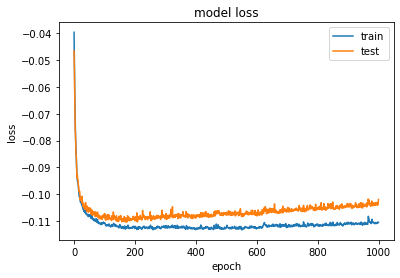

In [17]:
#evaluations
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [18]:
predictions = autoencoder.predict(df_Test)

mse = np.mean(np.power(df_Test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': Y_test})
error_df.describe()

,reconstruction_error,true_class
count,27786.000000,27786.000000
mean,0.967087,0.004679
std,0.475238,0.068241
min,0.263978,0.000000
25%,0.693193,0.000000
50%,0.835686,0.000000
75%,1.078873,0.000000
max,14.897316,1.000000


In [58]:
thres = [1.8,1.9,2,2.1,2.2]
for val in thres:
    y_pred = [1 if e > val else 0 for e in error_df.reconstruction_error.values]
    print(classification_report(Y_test,y_pred))
    

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     27656
           1       0.02      0.22      0.04       130

    accuracy                           0.95     27786
   macro avg       0.51      0.58      0.50     27786
weighted avg       0.99      0.95      0.97     27786

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     27656
           1       0.02      0.20      0.04       130

    accuracy                           0.95     27786
   macro avg       0.51      0.58      0.51     27786
weighted avg       0.99      0.95      0.97     27786

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     27656
           1       0.02      0.18      0.04       130

    accuracy                           0.96     27786
   macro avg       0.51      0.57      0.51     27786
weighted avg       0.99      0.96      0.98     27786

              preci

In order to predict whether or not a new/unseen transaction is normal or fraudulent, we’ll calculate the reconstruction error from the transaction data itself.   
If the error is larger than a predefined threshold, we’ll mark it as a fraud (since our model should have a low error on normal transactions).   
Picking a value as .004 times the mean .( Chosen empirically)

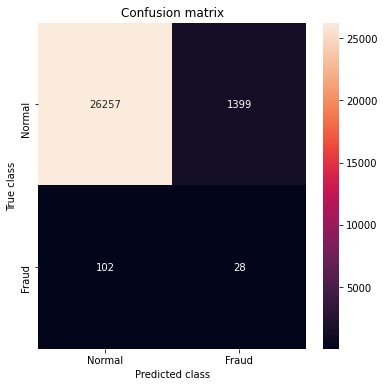

In [59]:
# predictions
#threshold = (3.484177e+07)*.1
thres = [.001,.01,.1,1,2,3,10,50,100]
threshold = 1.8
LABELS = ["Normal", "Fraud"]
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [60]:
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     27656
           1       0.02      0.22      0.04       130

    accuracy                           0.95     27786
   macro avg       0.51      0.58      0.50     27786
weighted avg       0.99      0.95      0.97     27786



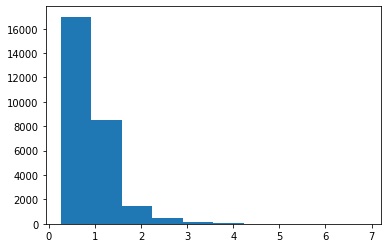

In [61]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

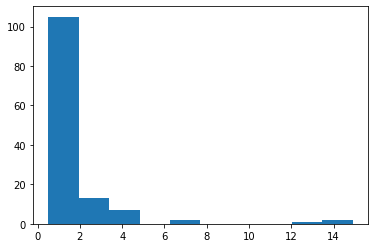

In [62]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [63]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)


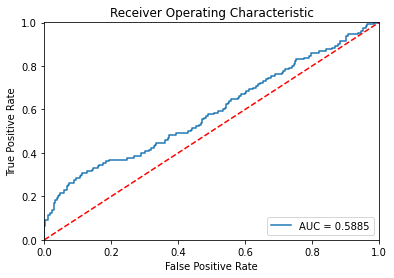

In [64]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

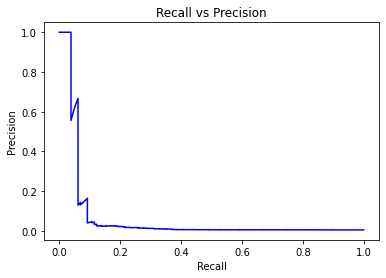

In [65]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

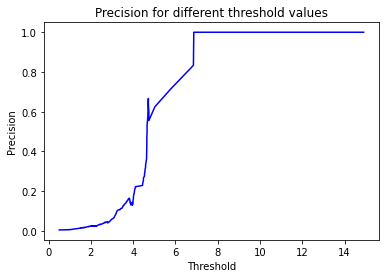

In [66]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

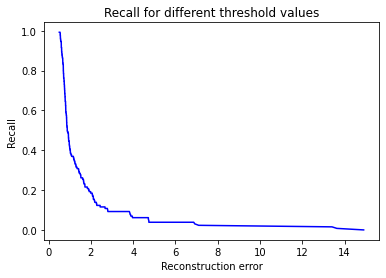

In [67]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

###        ( 0.02 ,     0.22 ,     0.04   ) was the best precision,recall and f1-score obtained.    


### We build a new model with early stopping and more number of hidden layers

In [110]:
import keras
from keras.callbacks import EarlyStopping
from keras import layers,activations,models,optimizers,losses,metrics

In [111]:
n_features = df_Train.shape[1]

encoder = models.Sequential(name='encoder')
encoder.add(layer = layers.Dense(units =20,activation = activations.relu,input_shape =[n_features]))
encoder.add(layers.Dropout(0.1))
encoder.add(layer = layers.Dense(units =10,activation = activations.relu))
encoder.add(layer = layers.Dense(units =5,activation = activations.relu))

decoder = models.Sequential(name='decoder')
decoder.add(layer = layers.Dense(units =10,activation = activations.relu,input_shape =[5]))
decoder.add(layer = layers.Dense(units =20,activation = activations.relu))
decoder.add(layers.Dropout(0.1))
decoder.add(layer = layers.Dense(units = n_features,activation = activations.sigmoid))

autoencoder = models.Sequential([encoder,decoder])

autoencoder.compile(optimizer = optimizers.Adam(), 
                    loss = losses.MSE,
                    metrics=[metrics.mean_squared_error])


In [112]:
autoencoder

Epoch 1/200
4053/4053 [==============================] - 12s 3ms/step - loss: 0.9992 - mean_squared_error: 0.9992 - val_loss: 0.9727 - val_mean_squared_error: 0.9727
Epoch 2/200
4053/4053 [==============================] - 12s 3ms/step - loss: 0.9945 - mean_squared_error: 0.9945 - val_loss: 0.9710 - val_mean_squared_error: 0.9710
Epoch 3/200
4053/4053 [==============================] - 20s 5ms/step - loss: 0.9934 - mean_squared_error: 0.9934 - val_loss: 0.9703 - val_mean_squared_error: 0.9703
Epoch 4/200
4053/4053 [==============================] - 55s 14ms/step - loss: 0.9929 - mean_squared_error: 0.9929 - val_loss: 0.9700 - val_mean_squared_error: 0.9700
Epoch 5/200
4053/4053 [==============================] - 15s 4ms/step - loss: 0.9927 - mean_squared_error: 0.9927 - val_loss: 0.9699 - val_mean_squared_error: 0.9699
Epoch 6/200
4053/4053 [==============================] - 13s 3ms/step - loss: 0.9926 - mean_squared_error: 0.9926 - val_loss: 0.9697 - val_mean_squared_error: 0.9697
Epo

No handles with labels found to put in legend.


<function matplotlib.pyplot.show(close=None, block=None)>

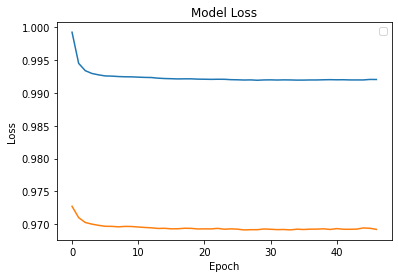

In [113]:
# train model
es = EarlyStopping(monitor = 'val_loss',
                   min_delta = 0.00001,
                  patience = 20,
                  restore_best_weights = True)
history = autoencoder.fit(x = df_Train,y= df_Train,
                          epochs = 200,
                          verbose = 1,
                          validation_data = (df_Test,df_Test),
                          callbacks = [es])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show



In [115]:
train_predicted_x = autoencoder.predict(x = df_Train)
train_events_mse = losses.mean_squared_error(df_Train,train_predicted_x)
cutoff = np.percentile(train_events_mse,95)

In [116]:
cutoff

1.772678446769714

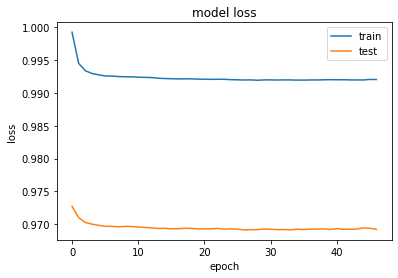

In [122]:
#evaluations
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [123]:
mse = np.mean(np.power(df_Train - train_predicted_x, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': Y_train})
error_df.describe()

,reconstruction_error,true_class
count,129668.000000,129668.000000
mean,0.991493,0.005437
std,1.383220,0.073535
min,0.245432,0.000000
25%,0.704183,0.000000
50%,0.846332,0.000000
75%,1.074270,0.000000
max,121.591761,1.000000


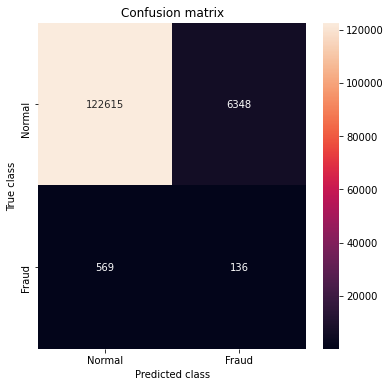

In [125]:
# predictions
#threshold = (3.484177e+07)*.1
thres = [.001,.01,.1,1,2,3,10,50,100]
threshold = 1.772678446769714
LABELS = ["Normal", "Fraud"]
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [131]:

print(classification_report(error_df.true_class,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    128963
           1       0.03      0.13      0.05       705

    accuracy                           0.97    129668
   macro avg       0.51      0.55      0.52    129668
weighted avg       0.99      0.97      0.98    129668



#### (0.02, 0.22, 0.04) was the precision,recall and f1-score obtained by model1  
#### (0.03, 0.13, 0.05) was the precision,recall and f1-score obtained by model2
#### We did not find much improvement over earlier model with 4 layers and no early stopping

### Trying  increasing the number of neurons in each layer


Epoch 1/200
4053/4053 [==============================] - 25s 6ms/step - loss: 0.9977 - mean_squared_error: 0.9977 - val_loss: 0.9748 - val_mean_squared_error: 0.9748
Epoch 2/200
4053/4053 [==============================] - 21s 5ms/step - loss: 0.9972 - mean_squared_error: 0.9972 - val_loss: 0.9748 - val_mean_squared_error: 0.9748
Epoch 3/200
4053/4053 [==============================] - 24s 6ms/step - loss: 0.9972 - mean_squared_error: 0.9972 - val_loss: 0.9748 - val_mean_squared_error: 0.9748
Epoch 4/200
4053/4053 [==============================] - 15s 4ms/step - loss: 0.9972 - mean_squared_error: 0.9972 - val_loss: 0.9748 - val_mean_squared_error: 0.9748
Epoch 5/200
4053/4053 [==============================] - 15s 4ms/step - loss: 0.9972 - mean_squared_error: 0.9972 - val_loss: 0.9748 - val_mean_squared_error: 0.9748
Epoch 6/200
4053/4053 [==============================] - 18s 4ms/step - loss: 0.9972 - mean_squared_error: 0.9972 - val_loss: 0.9748 - val_mean_squared_error: 0.9748
Epoc

No handles with labels found to put in legend.


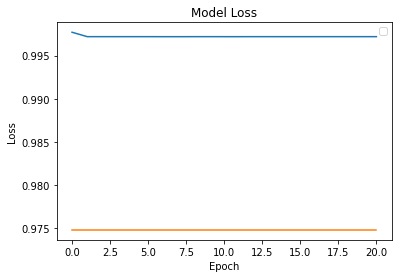

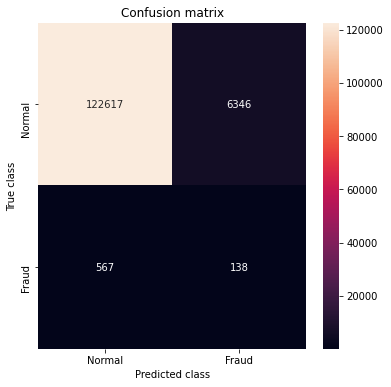

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    128963
           1       0.02      0.20      0.04       705

    accuracy                           0.95    129668
   macro avg       0.51      0.57      0.51    129668
weighted avg       0.99      0.95      0.97    129668



In [133]:
n_features = df_Train.shape[1]

encoder = models.Sequential(name='encoder')
encoder.add(layer = layers.Dense(units =200,activation = activations.relu,input_shape =[n_features]))
encoder.add(layers.Dropout(0.1))
encoder.add(layer = layers.Dense(units =100,activation = activations.relu))
encoder.add(layer = layers.Dense(units =50,activation = activations.relu))

decoder = models.Sequential(name='decoder')
decoder.add(layer = layers.Dense(units =100,activation = activations.relu,input_shape =[50]))
decoder.add(layer = layers.Dense(units =200,activation = activations.relu))
decoder.add(layers.Dropout(0.1))
decoder.add(layer = layers.Dense(units = n_features,activation = activations.sigmoid))

autoencoder = models.Sequential([encoder,decoder])

autoencoder.compile(optimizer = optimizers.Adam(), 
                    loss = losses.MSE,
                    metrics=[metrics.mean_squared_error])
# train model
es = EarlyStopping(monitor = 'val_loss',
                   min_delta = 0.00001,
                  patience = 20,
                  restore_best_weights = True)
history = autoencoder.fit(x = df_Train,y= df_Train,
                          epochs = 200,
                          verbose = 1,
                          validation_data = (df_Test,df_Test),
                          callbacks = [es])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show

# predictions 
train_predicted_x = autoencoder.predict(x = df_Train)
train_events_mse = losses.mean_squared_error(df_Train,train_predicted_x)
cutoff = np.percentile(train_events_mse,95)


mse = np.mean(np.power(df_Train - train_predicted_x, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': Y_train})
error_df.describe()

# plot the confusion matrix 
LABELS = ["Normal", "Fraud"]
y_pred = [1 if e > cutoff else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

print(classification_report(error_df.true_class,y_pred))

#### (0.02, 0.22, 0.04) was the precision,recall and f1-score obtained by model1  
#### (0.03, 0.13, 0.05) was the precision,recall and f1-score obtained by model2
#### (0.02, 0.20, 0.04) was the precision,recall and f1-score obtained by model3

### We see that increasing the number of neurons did not improve the model performace


### after removing the dropout  layer

Epoch 1/200
4053/4053 [==============================] - 32s 8ms/step - loss: 0.9977 - mean_squared_error: 0.9977 - val_loss: 0.9748 - val_mean_squared_error: 0.9748
Epoch 2/200
4053/4053 [==============================] - 39s 10ms/step - loss: 0.9972 - mean_squared_error: 0.9972 - val_loss: 0.9748 - val_mean_squared_error: 0.9748
Epoch 3/200
4053/4053 [==============================] - 21s 5ms/step - loss: 0.9972 - mean_squared_error: 0.9972 - val_loss: 0.9748 - val_mean_squared_error: 0.9748
Epoch 4/200
4053/4053 [==============================] - 18s 4ms/step - loss: 0.9972 - mean_squared_error: 0.9972 - val_loss: 0.9748 - val_mean_squared_error: 0.9748
Epoch 5/200
4053/4053 [==============================] - 20s 5ms/step - loss: 0.9972 - mean_squared_error: 0.9972 - val_loss: 0.9748 - val_mean_squared_error: 0.9748
Epoch 6/200
4053/4053 [==============================] - 16s 4ms/step - loss: 0.9972 - mean_squared_error: 0.9972 - val_loss: 0.9748 - val_mean_squared_error: 0.9748
Epo

No handles with labels found to put in legend.


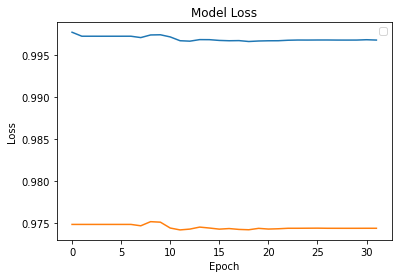

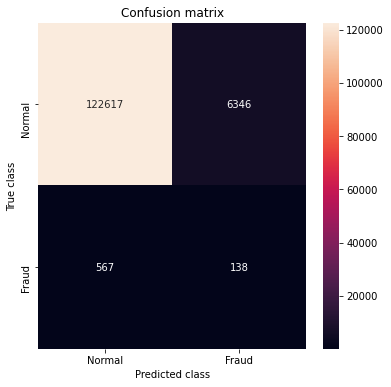

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    128963
           1       0.02      0.20      0.04       705

    accuracy                           0.95    129668
   macro avg       0.51      0.57      0.51    129668
weighted avg       0.99      0.95      0.97    129668



In [135]:
n_features = df_Train.shape[1]

encoder = models.Sequential(name='encoder')
encoder.add(layer = layers.Dense(units =200,activation = activations.relu,input_shape =[n_features]))
#encoder.add(layers.Dropout(0.1))
encoder.add(layer = layers.Dense(units =100,activation = activations.relu))
encoder.add(layer = layers.Dense(units =50,activation = activations.relu))

decoder = models.Sequential(name='decoder')
decoder.add(layer = layers.Dense(units =100,activation = activations.relu,input_shape =[50]))
decoder.add(layer = layers.Dense(units =200,activation = activations.relu))
#decoder.add(layers.Dropout(0.1))
decoder.add(layer = layers.Dense(units = n_features,activation = activations.sigmoid))

autoencoder = models.Sequential([encoder,decoder])

autoencoder.compile(optimizer = optimizers.Adam(), 
                    loss = losses.MSE,
                    metrics=[metrics.mean_squared_error])
# train model
es = EarlyStopping(monitor = 'val_loss',
                   min_delta = 0.00001,
                  patience = 20,
                  restore_best_weights = True)
history = autoencoder.fit(x = df_Train,y= df_Train,
                          epochs = 200,
                          verbose = 1,
                          validation_data = (df_Test,df_Test),
                          callbacks = [es])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show

# predictions 
train_predicted_x = autoencoder.predict(x = df_Train)
train_events_mse = losses.mean_squared_error(df_Train,train_predicted_x)
cutoff = np.percentile(train_events_mse,95)


mse = np.mean(np.power(df_Train - train_predicted_x, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': Y_train})
error_df.describe()

# plot the confusion matrix 
LABELS = ["Normal", "Fraud"]
y_pred = [1 if e > cutoff else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

print(classification_report(error_df.true_class,y_pred))

#### (0.02, 0.22, 0.04) was the precision,recall and f1-score obtained by model1  
#### (0.03, 0.13, 0.05) was the precision,recall and f1-score obtained by model2
#### (0.02, 0.20, 0.04) was the precision,recall and f1-score obtained by model3
#### (0.02, 0.20, 0.04) was the precision,recall and f1-score obtained by model4
### We see that removing the dropout layer did not improve the model performace


### using tanh for activation function

Epoch 1/200
4053/4053 [==============================] - 55s 14ms/step - loss: 0.9944 - mean_squared_error: 0.9944 - val_loss: 0.9672 - val_mean_squared_error: 0.9672
Epoch 2/200
4053/4053 [==============================] - 19s 5ms/step - loss: 0.9885 - mean_squared_error: 0.9885 - val_loss: 0.9653 - val_mean_squared_error: 0.9653
Epoch 3/200
4053/4053 [==============================] - 14s 4ms/step - loss: 0.9876 - mean_squared_error: 0.9876 - val_loss: 0.9650 - val_mean_squared_error: 0.9650
Epoch 4/200
4053/4053 [==============================] - 13s 3ms/step - loss: 0.9872 - mean_squared_error: 0.9872 - val_loss: 0.9646 - val_mean_squared_error: 0.9646
Epoch 5/200
4053/4053 [==============================] - 13s 3ms/step - loss: 0.9867 - mean_squared_error: 0.9867 - val_loss: 0.9641 - val_mean_squared_error: 0.9641
Epoch 6/200
4053/4053 [==============================] - 15s 4ms/step - loss: 0.9862 - mean_squared_error: 0.9862 - val_loss: 0.9636 - val_mean_squared_error: 0.9636
Epo

4053/4053 [==============================] - 12s 3ms/step - loss: 0.9688 - mean_squared_error: 0.9688 - val_loss: 0.9464 - val_mean_squared_error: 0.9464
Epoch 51/200
4053/4053 [==============================] - 28s 7ms/step - loss: 0.9686 - mean_squared_error: 0.9686 - val_loss: 0.9464 - val_mean_squared_error: 0.9464
Epoch 52/200
4053/4053 [==============================] - 17s 4ms/step - loss: 0.9685 - mean_squared_error: 0.9685 - val_loss: 0.9461 - val_mean_squared_error: 0.9461
Epoch 53/200
4053/4053 [==============================] - 13s 3ms/step - loss: 0.9683 - mean_squared_error: 0.9683 - val_loss: 0.9459 - val_mean_squared_error: 0.9459
Epoch 54/200
4053/4053 [==============================] - 13s 3ms/step - loss: 0.9681 - mean_squared_error: 0.9681 - val_loss: 0.9457 - val_mean_squared_error: 0.9457
Epoch 55/200
4053/4053 [==============================] - 16s 4ms/step - loss: 0.9678 - mean_squared_error: 0.9678 - val_loss: 0.9455 - val_mean_squared_error: 0.9455
Epoch 56/20

Epoch 148/200
4053/4053 [==============================] - 12s 3ms/step - loss: 0.9574 - mean_squared_error: 0.9574 - val_loss: 0.9344 - val_mean_squared_error: 0.9344
Epoch 149/200
4053/4053 [==============================] - 12s 3ms/step - loss: 0.9574 - mean_squared_error: 0.9574 - val_loss: 0.9345 - val_mean_squared_error: 0.9345
Epoch 150/200
4053/4053 [==============================] - 12s 3ms/step - loss: 0.9574 - mean_squared_error: 0.9574 - val_loss: 0.9343 - val_mean_squared_error: 0.9343
Epoch 151/200
4053/4053 [==============================] - 12s 3ms/step - loss: 0.9574 - mean_squared_error: 0.9574 - val_loss: 0.9344 - val_mean_squared_error: 0.9344
Epoch 152/200
4053/4053 [==============================] - 12s 3ms/step - loss: 0.9573 - mean_squared_error: 0.9573 - val_loss: 0.9343 - val_mean_squared_error: 0.9343
Epoch 153/200
4053/4053 [==============================] - 12s 3ms/step - loss: 0.9573 - mean_squared_error: 0.9573 - val_loss: 0.9343 - val_mean_squared_error:

No handles with labels found to put in legend.


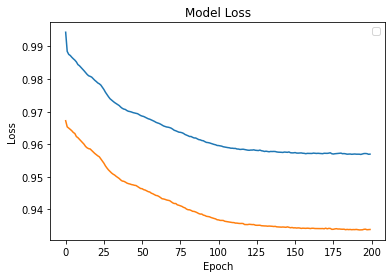

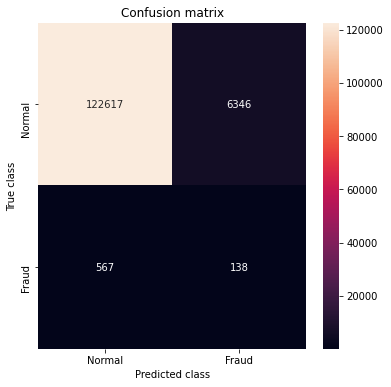

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    128963
           1       0.02      0.20      0.04       705

    accuracy                           0.95    129668
   macro avg       0.51      0.57      0.51    129668
weighted avg       0.99      0.95      0.97    129668



In [137]:
n_features = df_Train.shape[1]

encoder = models.Sequential(name='encoder')
encoder.add(layer = layers.Dense(units =200,activation = activations.tanh,input_shape =[n_features]))
encoder.add(layers.Dropout(0.1))
encoder.add(layer = layers.Dense(units =100,activation = activations.relu))
encoder.add(layer = layers.Dense(units =50,activation = activations.relu))

decoder = models.Sequential(name='decoder')
decoder.add(layer = layers.Dense(units =100,activation = activations.tanh,input_shape =[50]))
decoder.add(layer = layers.Dense(units =200,activation = activations.relu))
decoder.add(layers.Dropout(0.1))
decoder.add(layer = layers.Dense(units = n_features,activation = activations.sigmoid))

autoencoder = models.Sequential([encoder,decoder])

autoencoder.compile(optimizer = optimizers.Adam(), 
                    loss = losses.MSE,
                    metrics=[metrics.mean_squared_error])
# train model
es = EarlyStopping(monitor = 'val_loss',
                   min_delta = 0.00001,
                  patience = 20,
                  restore_best_weights = True)
history = autoencoder.fit(x = df_Train,y= df_Train,
                          epochs = 200,
                          verbose = 1,
                          validation_data = (df_Test,df_Test),
                          callbacks = [es])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show

# predictions and setting the threshold above 95 percentile
train_predicted_x = autoencoder.predict(x = df_Train)
train_events_mse = losses.mean_squared_error(df_Train,train_predicted_x)
cutoff = np.percentile(train_events_mse,95)


mse = np.mean(np.power(df_Train - train_predicted_x, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': Y_train})
error_df.describe()

# plot the confusion matrix 
LABELS = ["Normal", "Fraud"]
y_pred = [1 if e > cutoff else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

print(classification_report(error_df.true_class,y_pred))

#### (0.02, 0.22, 0.04) was the precision,recall and f1-score obtained by model1  
#### (0.03, 0.13, 0.05) was the precision,recall and f1-score obtained by model2
#### (0.02, 0.20, 0.04) was the precision,recall and f1-score obtained by model3
#### (0.02, 0.20, 0.04) was the precision,recall and f1-score obtained by model4
#### (0.02, 0.20, 0.04) was the precision,recall and f1-score obtained by model4 (tanh)
### We see that using the activation function as tanh did not improve the model performace


### changing the optimizer to SGD() 

Available optimizers
-SGD
-RMSprop
-Adam
-Adadelta
-Adagrad
-Adamax
-Nadam
-Ftrl

Epoch 1/200
4053/4053 [==============================] - 31s 8ms/step - loss: 1.2426 - mean_squared_error: 1.2426 - val_loss: 1.2076 - val_mean_squared_error: 1.2076
Epoch 2/200
4053/4053 [==============================] - 18s 4ms/step - loss: 1.0855 - mean_squared_error: 1.0855 - val_loss: 0.9757 - val_mean_squared_error: 0.9757
Epoch 3/200
4053/4053 [==============================] - 15s 4ms/step - loss: 0.9984 - mean_squared_error: 0.9984 - val_loss: 0.9749 - val_mean_squared_error: 0.9749
Epoch 4/200
4053/4053 [==============================] - 10s 2ms/step - loss: 0.9977 - mean_squared_error: 0.9977 - val_loss: 0.9749 - val_mean_squared_error: 0.9749
Epoch 5/200
4053/4053 [==============================] - 13s 3ms/step - loss: 0.9975 - mean_squared_error: 0.9975 - val_loss: 0.9748 - val_mean_squared_error: 0.9748
Epoch 6/200
4053/4053 [==============================] - 15s 4ms/step - loss: 0.9974 - mean_squared_error: 0.9974 - val_loss: 0.9748 - val_mean_squared_error: 0.9748
Epoc

No handles with labels found to put in legend.


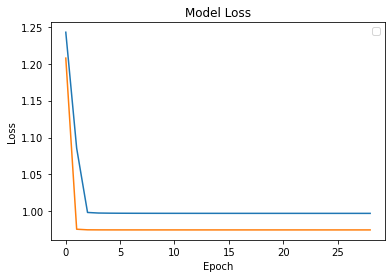

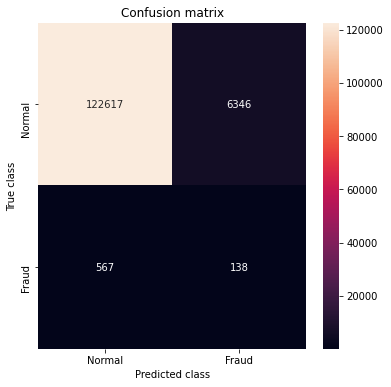

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    128963
           1       0.02      0.20      0.04       705

    accuracy                           0.95    129668
   macro avg       0.51      0.57      0.51    129668
weighted avg       0.99      0.95      0.97    129668



In [139]:
n_features = df_Train.shape[1]

encoder = models.Sequential(name='encoder')
encoder.add(layer = layers.Dense(units =200,activation = activations.relu,input_shape =[n_features]))
encoder.add(layers.Dropout(0.1))
encoder.add(layer = layers.Dense(units =100,activation = activations.relu))
encoder.add(layer = layers.Dense(units =50,activation = activations.relu))

decoder = models.Sequential(name='decoder')
decoder.add(layer = layers.Dense(units =100,activation = activations.relu,input_shape =[50]))
decoder.add(layer = layers.Dense(units =200,activation = activations.relu))
decoder.add(layers.Dropout(0.1))
decoder.add(layer = layers.Dense(units = n_features,activation = activations.sigmoid))

autoencoder = models.Sequential([encoder,decoder])

autoencoder.compile(optimizer = optimizers.SGD(), 
                    loss = losses.MSE,
                    metrics=[metrics.mean_squared_error])
# train model
es = EarlyStopping(monitor = 'val_loss',
                   min_delta = 0.00001,
                  patience = 20,
                  restore_best_weights = True)
history = autoencoder.fit(x = df_Train,y= df_Train,
                          epochs = 200,
                          verbose = 1,
                          validation_data = (df_Test,df_Test),
                          callbacks = [es])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show

# predictions and setting the threshold above 95 percentile
train_predicted_x = autoencoder.predict(x = df_Train)
train_events_mse = losses.mean_squared_error(df_Train,train_predicted_x)
cutoff = np.percentile(train_events_mse,95)


mse = np.mean(np.power(df_Train - train_predicted_x, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': Y_train})
error_df.describe()

# plot the confusion matrix 
LABELS = ["Normal", "Fraud"]
y_pred = [1 if e > cutoff else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

print(classification_report(error_df.true_class,y_pred))

In [144]:
# for RMS prop
def get_results(opt = optimizers.RMSprop() ):
    n_features = df_Train.shape[1]

    encoder = models.Sequential(name='encoder')
    encoder.add(layer = layers.Dense(units =200,activation = activations.relu,input_shape =[n_features]))
    encoder.add(layers.Dropout(0.1))
    encoder.add(layer = layers.Dense(units =100,activation = activations.relu))
    encoder.add(layer = layers.Dense(units =50,activation = activations.relu))

    decoder = models.Sequential(name='decoder')
    decoder.add(layer = layers.Dense(units =100,activation = activations.relu,input_shape =[50]))
    decoder.add(layer = layers.Dense(units =200,activation = activations.relu))
    decoder.add(layers.Dropout(0.1))
    decoder.add(layer = layers.Dense(units = n_features,activation = activations.sigmoid))

    autoencoder = models.Sequential([encoder,decoder])

    autoencoder.compile(optimizer = opt, 
                        loss = losses.MSE,
                        metrics=[metrics.mean_squared_error])
    # train model
    es = EarlyStopping(monitor = 'val_loss',
                       min_delta = 0.00001,
                      patience = 20,
                      restore_best_weights = True)
    history = autoencoder.fit(x = df_Train,y= df_Train,
                              epochs = 200,
                              verbose = 0,
                              validation_data = (df_Test,df_Test),
                              callbacks = [es])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show

    # predictions and setting the threshold above 95 percentile
    train_predicted_x = autoencoder.predict(x = df_Train)
    train_events_mse = losses.mean_squared_error(df_Train,train_predicted_x)
    cutoff = np.percentile(train_events_mse,95)


    mse = np.mean(np.power(df_Train - train_predicted_x, 2), axis=1)
    error_df = pd.DataFrame({'reconstruction_error': mse,
                            'true_class': Y_train})
    error_df.describe()

    # plot the confusion matrix 
    LABELS = ["Normal", "Fraud"]
    y_pred = [1 if e > cutoff else 0 for e in error_df.reconstruction_error.values]
    conf_matrix = confusion_matrix(error_df.true_class, y_pred)

    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

    print(classification_report(error_df.true_class,y_pred))

Epoch 1/200
4053/4053 [==============================] - 30s 7ms/step - loss: 0.9926 - mean_squared_error: 0.9926 - val_loss: 0.9672 - val_mean_squared_error: 0.9672
Epoch 2/200
4053/4053 [==============================] - 27s 7ms/step - loss: 0.9891 - mean_squared_error: 0.9891 - val_loss: 0.9658 - val_mean_squared_error: 0.9658
Epoch 3/200
4053/4053 [==============================] - 22s 6ms/step - loss: 0.9886 - mean_squared_error: 0.9886 - val_loss: 0.9667 - val_mean_squared_error: 0.9667
Epoch 4/200
4053/4053 [==============================] - 19s 5ms/step - loss: 0.9887 - mean_squared_error: 0.9887 - val_loss: 0.9655 - val_mean_squared_error: 0.9655
Epoch 5/200
4053/4053 [==============================] - 19s 5ms/step - loss: 0.9887 - mean_squared_error: 0.9887 - val_loss: 0.9658 - val_mean_squared_error: 0.9658
Epoch 6/200
4053/4053 [==============================] - 20s 5ms/step - loss: 0.9889 - mean_squared_error: 0.9889 - val_loss: 0.9658 - val_mean_squared_error: 0.9658
Epoc

No handles with labels found to put in legend.


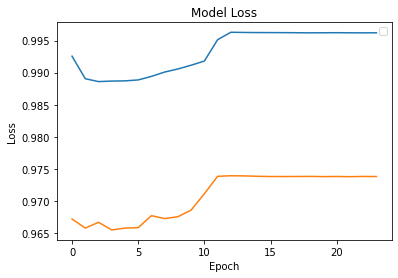

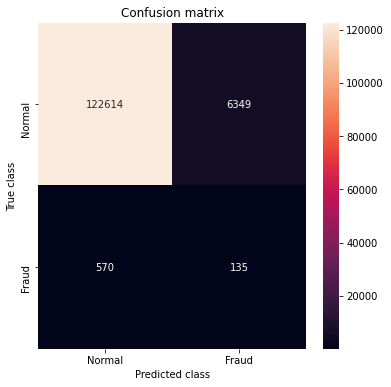

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    128963
           1       0.02      0.19      0.04       705

    accuracy                           0.95    129668
   macro avg       0.51      0.57      0.51    129668
weighted avg       0.99      0.95      0.97    129668



In [142]:
get_results(opt = optimizers.RMSprop())

No handles with labels found to put in legend.


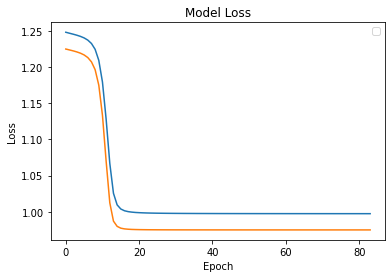

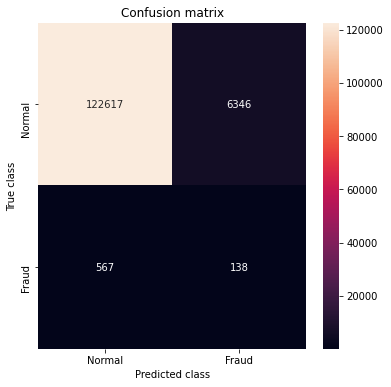

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    128963
           1       0.02      0.20      0.04       705

    accuracy                           0.95    129668
   macro avg       0.51      0.57      0.51    129668
weighted avg       0.99      0.95      0.97    129668

CPU times: user 1h 14min 29s, sys: 10min 30s, total: 1h 25min
Wall time: 21min 43s


In [145]:
%%time
get_results(opt = optimizers.Adadelta())

No handles with labels found to put in legend.


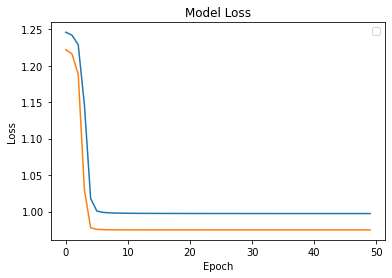

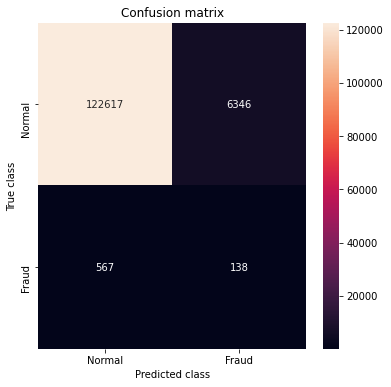

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    128963
           1       0.02      0.20      0.04       705

    accuracy                           0.95    129668
   macro avg       0.51      0.57      0.51    129668
weighted avg       0.99      0.95      0.97    129668

CPU times: user 37min 32s, sys: 5min 7s, total: 42min 40s
Wall time: 13min 12s


In [157]:
%%time
get_results(opt = optimizers.Adagrad())

No handles with labels found to put in legend.


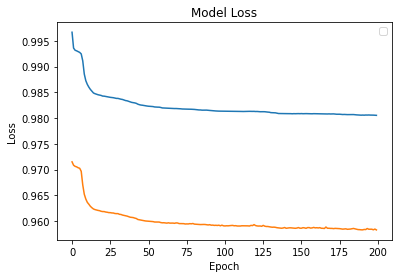

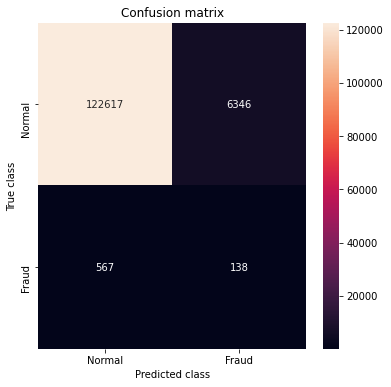

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    128963
           1       0.02      0.20      0.04       705

    accuracy                           0.95    129668
   macro avg       0.51      0.57      0.51    129668
weighted avg       0.99      0.95      0.97    129668

CPU times: user 2h 38min 24s, sys: 18min 52s, total: 2h 57min 16s
Wall time: 43min 7s


In [158]:
%%time
get_results(opt = optimizers.Adamax())

No handles with labels found to put in legend.


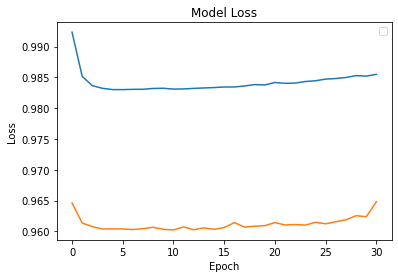

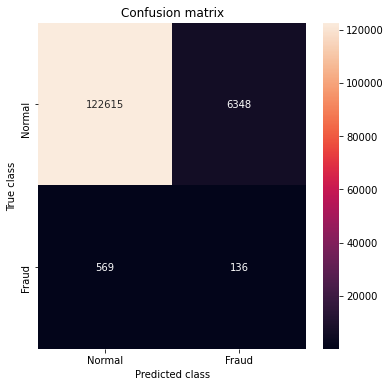

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    128963
           1       0.02      0.19      0.04       705

    accuracy                           0.95    129668
   macro avg       0.51      0.57      0.51    129668
weighted avg       0.99      0.95      0.97    129668

CPU times: user 48min 53s, sys: 14min 55s, total: 1h 3min 49s
Wall time: 15min 31s


In [159]:
%%time
get_results(opt = optimizers.Nadam())

No handles with labels found to put in legend.


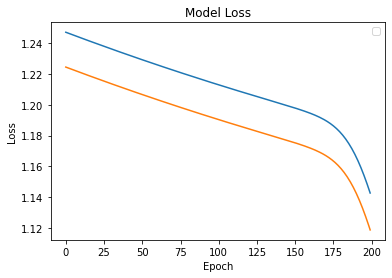

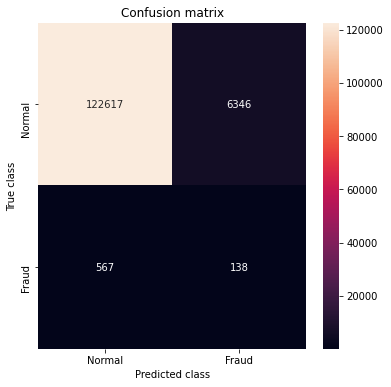

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    128963
           1       0.02      0.20      0.04       705

    accuracy                           0.95    129668
   macro avg       0.51      0.57      0.51    129668
weighted avg       0.99      0.95      0.97    129668

CPU times: user 3h 21min 52s, sys: 27min 45s, total: 3h 49min 38s
Wall time: 57min 22s


In [161]:
%%time
get_results(opt = optimizers.Ftrl())

## batch size 256

Epoch 1/200
507/507 [==============================] - 12s 23ms/step - loss: -0.0573 - accuracy: 9.4086e-04 - val_loss: -0.0694 - val_accuracy: 6.4781e-04
Epoch 2/200
507/507 [==============================] - 8s 15ms/step - loss: -0.0718 - accuracy: 0.0014 - val_loss: -0.0725 - val_accuracy: 0.0024
Epoch 3/200
507/507 [==============================] - 11s 22ms/step - loss: -0.0743 - accuracy: 0.0027 - val_loss: -0.0741 - val_accuracy: 0.0032
Epoch 4/200
507/507 [==============================] - 7s 13ms/step - loss: -0.0764 - accuracy: 0.0040 - val_loss: -0.0768 - val_accuracy: 0.0048
Epoch 5/200
507/507 [==============================] - 6s 12ms/step - loss: -0.0785 - accuracy: 0.0043 - val_loss: -0.0785 - val_accuracy: 0.0020
Epoch 6/200
507/507 [==============================] - 6s 13ms/step - loss: -0.0804 - accuracy: 0.0025 - val_loss: -0.0800 - val_accuracy: 0.0034
Epoch 7/200
507/507 [==============================] - 6s 12ms/step - loss: -0.0820 - accuracy: 0.0021 - val_loss:

Epoch 29/200
507/507 [==============================] - 6s 11ms/step - loss: -0.1171 - accuracy: 0.0192 - val_loss: -0.1161 - val_accuracy: 0.0182
Epoch 30/200
507/507 [==============================] - 5s 11ms/step - loss: -0.1186 - accuracy: 0.0179 - val_loss: -0.1171 - val_accuracy: 0.0184
Epoch 31/200
507/507 [==============================] - 5s 11ms/step - loss: -0.1200 - accuracy: 0.0185 - val_loss: -0.1187 - val_accuracy: 0.0178
Epoch 32/200
507/507 [==============================] - 5s 10ms/step - loss: -0.1212 - accuracy: 0.0180 - val_loss: -0.1185 - val_accuracy: 0.0183
Epoch 33/200
507/507 [==============================] - 6s 12ms/step - loss: -0.1216 - accuracy: 0.0178 - val_loss: -0.1195 - val_accuracy: 0.0191
Epoch 34/200
507/507 [==============================] - 6s 11ms/step - loss: -0.1229 - accuracy: 0.0167 - val_loss: -0.1207 - val_accuracy: 0.0186
Epoch 35/200
507/507 [==============================] - 6s 11ms/step - loss: -0.1235 - accuracy: 0.0162 - val_loss: -0

Epoch 61/200
507/507 [==============================] - 6s 12ms/step - loss: -0.1439 - accuracy: 0.0219 - val_loss: -0.1418 - val_accuracy: 0.0233
Epoch 62/200
507/507 [==============================] - 6s 12ms/step - loss: -0.1447 - accuracy: 0.0235 - val_loss: -0.1429 - val_accuracy: 0.0217
Epoch 63/200
507/507 [==============================] - 5s 10ms/step - loss: -0.1456 - accuracy: 0.0224 - val_loss: -0.1419 - val_accuracy: 0.0211
Epoch 64/200
507/507 [==============================] - 6s 11ms/step - loss: -0.1458 - accuracy: 0.0217 - val_loss: -0.1431 - val_accuracy: 0.0199
Epoch 65/200
507/507 [==============================] - 6s 12ms/step - loss: -0.1465 - accuracy: 0.0228 - val_loss: -0.1433 - val_accuracy: 0.0227
Epoch 66/200
507/507 [==============================] - 5s 10ms/step - loss: -0.1458 - accuracy: 0.0233 - val_loss: -0.1427 - val_accuracy: 0.0255
Epoch 67/200
507/507 [==============================] - 5s 10ms/step - loss: -0.1464 - accuracy: 0.0227 - val_loss: -0

507/507 [==============================] - 5s 10ms/step - loss: -0.1572 - accuracy: 0.0258 - val_loss: -0.1540 - val_accuracy: 0.0230
Epoch 98/200
507/507 [==============================] - 5s 10ms/step - loss: -0.1569 - accuracy: 0.0252 - val_loss: -0.1537 - val_accuracy: 0.0232
Epoch 99/200
507/507 [==============================] - 7s 13ms/step - loss: -0.1579 - accuracy: 0.0248 - val_loss: -0.1545 - val_accuracy: 0.0225
Epoch 100/200
507/507 [==============================] - 6s 11ms/step - loss: -0.1585 - accuracy: 0.0241 - val_loss: -0.1553 - val_accuracy: 0.0263
Epoch 101/200
507/507 [==============================] - 5s 10ms/step - loss: -0.1577 - accuracy: 0.0265 - val_loss: -0.1550 - val_accuracy: 0.0242
Epoch 102/200
507/507 [==============================] - 5s 11ms/step - loss: -0.1581 - accuracy: 0.0244 - val_loss: -0.1528 - val_accuracy: 0.0246
Epoch 103/200
507/507 [==============================] - 5s 11ms/step - loss: -0.1578 - accuracy: 0.0253 - val_loss: -0.1548 - v

507/507 [==============================] - 5s 10ms/step - loss: -0.1638 - accuracy: 0.0269 - val_loss: -0.1588 - val_accuracy: 0.0255
Epoch 140/200
507/507 [==============================] - 6s 11ms/step - loss: -0.1636 - accuracy: 0.0254 - val_loss: -0.1599 - val_accuracy: 0.0260
Epoch 141/200
507/507 [==============================] - 6s 11ms/step - loss: -0.1643 - accuracy: 0.0283 - val_loss: -0.1592 - val_accuracy: 0.0272
Epoch 142/200
507/507 [==============================] - 6s 11ms/step - loss: -0.1635 - accuracy: 0.0284 - val_loss: -0.1583 - val_accuracy: 0.0262
Epoch 143/200
507/507 [==============================] - 5s 10ms/step - loss: -0.1639 - accuracy: 0.0248 - val_loss: -0.1598 - val_accuracy: 0.0213
Epoch 144/200
507/507 [==============================] - 6s 12ms/step - loss: -0.1646 - accuracy: 0.0238 - val_loss: -0.1606 - val_accuracy: 0.0266
Epoch 145/200
507/507 [==============================] - 6s 12ms/step - loss: -0.1654 - accuracy: 0.0269 - val_loss: -0.1616 -

507/507 [==============================] - 5s 11ms/step - loss: -0.1676 - accuracy: 0.0285 - val_loss: -0.1627 - val_accuracy: 0.0281
Epoch 185/200
507/507 [==============================] - 6s 11ms/step - loss: -0.1668 - accuracy: 0.0285 - val_loss: -0.1632 - val_accuracy: 0.0295
Epoch 186/200
507/507 [==============================] - 6s 11ms/step - loss: -0.1668 - accuracy: 0.0301 - val_loss: -0.1624 - val_accuracy: 0.0279
Epoch 187/200
507/507 [==============================] - 6s 11ms/step - loss: -0.1672 - accuracy: 0.0282 - val_loss: -0.1632 - val_accuracy: 0.0307
Epoch 188/200
507/507 [==============================] - 6s 11ms/step - loss: -0.1678 - accuracy: 0.0292 - val_loss: -0.1637 - val_accuracy: 0.0285
Epoch 189/200
507/507 [==============================] - 6s 11ms/step - loss: -0.1680 - accuracy: 0.0289 - val_loss: -0.1639 - val_accuracy: 0.0308
Epoch 190/200
507/507 [==============================] - 6s 11ms/step - loss: -0.1683 - accuracy: 0.0274 - val_loss: -0.1638 -

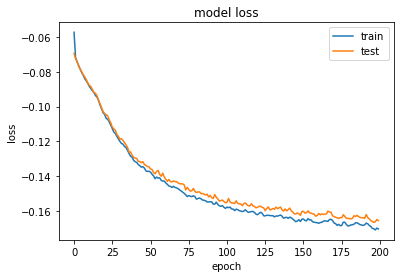

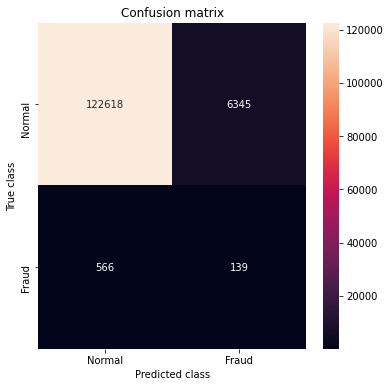

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    128963
           1       0.02      0.20      0.04       705

    accuracy                           0.95    129668
   macro avg       0.51      0.57      0.51    129668
weighted avg       0.99      0.95      0.97    129668

CPU times: user 54min 14s, sys: 34min 47s, total: 1h 29min 1s
Wall time: 21min 30s


In [165]:
%%time
# building the model
input_dim = df_Train.shape[1]

encoding_dim = 14

input_layer = Input(shape=(input_dim, ))
layer1 = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer) # encoder
layer2 = Dense(int(encoding_dim / 2), activation="relu")(layer1)          # encode
layer3 = Dense(int(encoding_dim / 2), activation='tanh')(layer2)          # decoder
layer4 = Dense(input_dim, activation='relu')(layer3)                      # decoder
autoencoder = Model(inputs=input_layer, outputs=layer4)
#training the model 
nb_epoch = 200
batch_size = 256
autoencoder.compile(optimizer='adam', 
                    #loss='mean_squared_error', 
                    loss = 'binary_crossentropy',
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h256",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(df_Train, df_Train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(df_Test, df_Test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

# loading the saved model
autoencoder = load_model('model.h256')


#evaluations
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');




# predictions = autoencoder.predict(df_Test)

# mse = np.mean(np.power(df_Test - predictions, 2), axis=1)
# error_df = pd.DataFrame({'reconstruction_error': mse,
#                         'true_class': Y_test})





# predictions and setting the threshold above 95 percentile
train_predicted_x = autoencoder.predict(x = df_Train)
train_events_mse = losses.mean_squared_error(df_Train,train_predicted_x)
cutoff = np.percentile(train_events_mse,95)


mse = np.mean(np.power(df_Train - train_predicted_x, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': Y_train})
error_df.describe()

# plot the confusion matrix 
LABELS = ["Normal", "Fraud"]
y_pred = [1 if e > cutoff else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

print(classification_report(error_df.true_class,y_pred))



## changing the percentile for cutoff

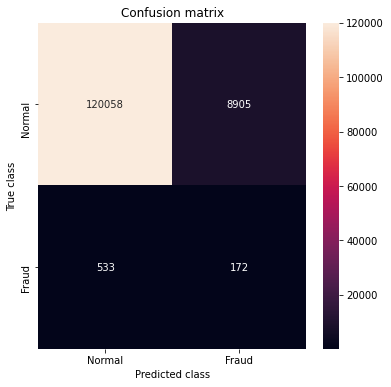

              precision    recall  f1-score   support

           0       1.00      0.93      0.96    128963
           1       0.02      0.24      0.04       705

    accuracy                           0.93    129668
   macro avg       0.51      0.59      0.50    129668
weighted avg       0.99      0.93      0.96    129668



In [170]:
# predictions and setting the threshold above 93 percentile
#train_predicted_x = autoencoder.predict(x = df_Train)
#train_events_mse = losses.mean_squared_error(df_Train,train_predicted_x)
cutoff = np.percentile(train_events_mse,93)


mse = np.mean(np.power(df_Train - train_predicted_x, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': Y_train})
error_df.describe()

# plot the confusion matrix 
LABELS = ["Normal", "Fraud"]
y_pred = [1 if e > cutoff else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

print(classification_report(error_df.true_class,y_pred))


### we see slight  improvement
### for batch size 512

Epoch 1/200
254/254 [==============================] - 16s 62ms/step - loss: -0.0771 - accuracy: 0.0018 - val_loss: -0.1017 - val_accuracy: 0.0037
Epoch 2/200
254/254 [==============================] - 11s 43ms/step - loss: -0.1086 - accuracy: 0.0044 - val_loss: -0.1130 - val_accuracy: 0.0032
Epoch 3/200
254/254 [==============================] - 7s 27ms/step - loss: -0.1160 - accuracy: 0.0035 - val_loss: -0.1185 - val_accuracy: 0.0035
Epoch 4/200
254/254 [==============================] - 7s 26ms/step - loss: -0.1189 - accuracy: 0.0031 - val_loss: -0.1201 - val_accuracy: 0.0035
Epoch 5/200
254/254 [==============================] - 6s 25ms/step - loss: -0.1221 - accuracy: 0.0042 - val_loss: -0.1226 - val_accuracy: 0.0058
Epoch 6/200
254/254 [==============================] - 9s 37ms/step - loss: -0.1238 - accuracy: 0.0057 - val_loss: -0.1242 - val_accuracy: 0.0042
Epoch 7/200
254/254 [==============================] - 9s 37ms/step - loss: -0.1257 - accuracy: 0.0049 - val_loss: -0.1260

Epoch 30/200
254/254 [==============================] - 7s 27ms/step - loss: -0.1510 - accuracy: 0.0091 - val_loss: -0.1502 - val_accuracy: 0.0113
Epoch 31/200
254/254 [==============================] - 6s 25ms/step - loss: -0.1524 - accuracy: 0.0089 - val_loss: -0.1513 - val_accuracy: 0.0095
Epoch 32/200
254/254 [==============================] - 6s 24ms/step - loss: -0.1536 - accuracy: 0.0087 - val_loss: -0.1532 - val_accuracy: 0.0127
Epoch 33/200
254/254 [==============================] - 6s 24ms/step - loss: -0.1552 - accuracy: 0.0096 - val_loss: -0.1543 - val_accuracy: 0.0092
Epoch 34/200
254/254 [==============================] - 7s 26ms/step - loss: -0.1552 - accuracy: 0.0090 - val_loss: -0.1536 - val_accuracy: 0.0097
Epoch 35/200
254/254 [==============================] - 12s 46ms/step - loss: -0.1555 - accuracy: 0.0095 - val_loss: -0.1543 - val_accuracy: 0.0129
Epoch 36/200
254/254 [==============================] - 8s 30ms/step - loss: -0.1567 - accuracy: 0.0127 - val_loss: -

254/254 [==============================] - 6s 24ms/step - loss: -0.1850 - accuracy: 0.0265 - val_loss: -0.1824 - val_accuracy: 0.0263
Epoch 61/200
254/254 [==============================] - 6s 25ms/step - loss: -0.1856 - accuracy: 0.0268 - val_loss: -0.1837 - val_accuracy: 0.0285
Epoch 62/200
254/254 [==============================] - 6s 24ms/step - loss: -0.1869 - accuracy: 0.0285 - val_loss: -0.1848 - val_accuracy: 0.0234
Epoch 63/200
254/254 [==============================] - 6s 22ms/step - loss: -0.1857 - accuracy: 0.0232 - val_loss: -0.1845 - val_accuracy: 0.0256
Epoch 64/200
254/254 [==============================] - 6s 25ms/step - loss: -0.1872 - accuracy: 0.0247 - val_loss: -0.1854 - val_accuracy: 0.0256
Epoch 65/200
254/254 [==============================] - 6s 24ms/step - loss: -0.1892 - accuracy: 0.0229 - val_loss: -0.1878 - val_accuracy: 0.0251
Epoch 66/200
254/254 [==============================] - 6s 22ms/step - loss: -0.1900 - accuracy: 0.0242 - val_loss: -0.1871 - val_a

254/254 [==============================] - 6s 24ms/step - loss: -0.2075 - accuracy: 0.0376 - val_loss: -0.2049 - val_accuracy: 0.0348
Epoch 93/200
254/254 [==============================] - 6s 24ms/step - loss: -0.2079 - accuracy: 0.0362 - val_loss: -0.2054 - val_accuracy: 0.0337
Epoch 94/200
254/254 [==============================] - 6s 24ms/step - loss: -0.2082 - accuracy: 0.0361 - val_loss: -0.2057 - val_accuracy: 0.0347
Epoch 95/200
254/254 [==============================] - 6s 24ms/step - loss: -0.2090 - accuracy: 0.0346 - val_loss: -0.2069 - val_accuracy: 0.0311
Epoch 96/200
254/254 [==============================] - 6s 24ms/step - loss: -0.2103 - accuracy: 0.0325 - val_loss: -0.2072 - val_accuracy: 0.0332
Epoch 97/200
254/254 [==============================] - 6s 25ms/step - loss: -0.2110 - accuracy: 0.0317 - val_loss: -0.2083 - val_accuracy: 0.0333
Epoch 98/200
254/254 [==============================] - 5s 21ms/step - loss: -0.2113 - accuracy: 0.0347 - val_loss: -0.2080 - val_a

Epoch 128/200
254/254 [==============================] - 6s 25ms/step - loss: -0.2231 - accuracy: 0.0387 - val_loss: -0.2201 - val_accuracy: 0.0410
Epoch 129/200
254/254 [==============================] - 5s 22ms/step - loss: -0.2229 - accuracy: 0.0388 - val_loss: -0.2194 - val_accuracy: 0.0425
Epoch 130/200
254/254 [==============================] - 6s 24ms/step - loss: -0.2240 - accuracy: 0.0416 - val_loss: -0.2212 - val_accuracy: 0.0461
Epoch 131/200
254/254 [==============================] - 6s 22ms/step - loss: -0.2247 - accuracy: 0.0428 - val_loss: -0.2211 - val_accuracy: 0.0446
Epoch 132/200
254/254 [==============================] - 6s 25ms/step - loss: -0.2250 - accuracy: 0.0468 - val_loss: -0.2217 - val_accuracy: 0.0461
Epoch 133/200
254/254 [==============================] - 6s 22ms/step - loss: -0.2247 - accuracy: 0.0477 - val_loss: -0.2216 - val_accuracy: 0.0480
Epoch 134/200
254/254 [==============================] - 6s 25ms/step - loss: -0.2247 - accuracy: 0.0496 - val_l

254/254 [==============================] - 6s 22ms/step - loss: -0.2356 - accuracy: 0.0487 - val_loss: -0.2322 - val_accuracy: 0.0455
Epoch 169/200
254/254 [==============================] - 6s 22ms/step - loss: -0.2356 - accuracy: 0.0481 - val_loss: -0.2321 - val_accuracy: 0.0501
Epoch 170/200
254/254 [==============================] - 6s 24ms/step - loss: -0.2361 - accuracy: 0.0496 - val_loss: -0.2333 - val_accuracy: 0.0433
Epoch 171/200
254/254 [==============================] - 6s 24ms/step - loss: -0.2379 - accuracy: 0.0475 - val_loss: -0.2350 - val_accuracy: 0.0455
Epoch 172/200
254/254 [==============================] - 5s 22ms/step - loss: -0.2384 - accuracy: 0.0475 - val_loss: -0.2347 - val_accuracy: 0.0498
Epoch 173/200
254/254 [==============================] - 6s 22ms/step - loss: -0.2385 - accuracy: 0.0523 - val_loss: -0.2348 - val_accuracy: 0.0518
Epoch 174/200
254/254 [==============================] - 6s 22ms/step - loss: -0.2382 - accuracy: 0.0508 - val_loss: -0.2345 -

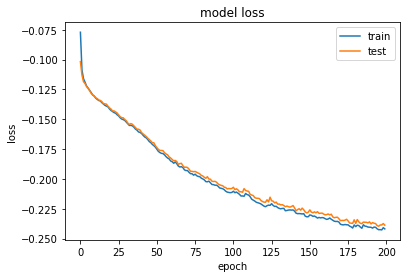

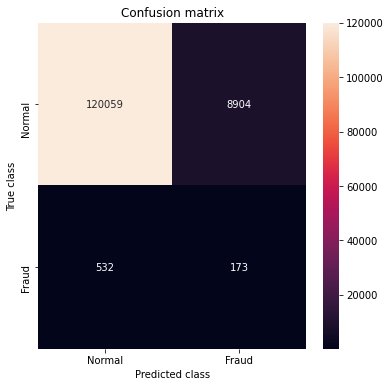

              precision    recall  f1-score   support

           0       1.00      0.93      0.96    128963
           1       0.02      0.25      0.04       705

    accuracy                           0.93    129668
   macro avg       0.51      0.59      0.50    129668
weighted avg       0.99      0.93      0.96    129668

CPU times: user 52min 57s, sys: 42min 39s, total: 1h 35min 36s
Wall time: 23min 7s


In [171]:
%%time
# building the model
input_dim = df_Train.shape[1]

encoding_dim = 14

input_layer = Input(shape=(input_dim, ))
layer1 = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer) # encoder
layer2 = Dense(int(encoding_dim / 2), activation="relu")(layer1)          # encode
layer3 = Dense(int(encoding_dim / 2), activation='tanh')(layer2)          # decoder
layer4 = Dense(input_dim, activation='relu')(layer3)                      # decoder
autoencoder = Model(inputs=input_layer, outputs=layer4)
#training the model 
nb_epoch = 200
batch_size = 512
autoencoder.compile(optimizer='adam', 
                    #loss='mean_squared_error', 
                    loss = 'binary_crossentropy',
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h512",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(df_Train, df_Train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(df_Test, df_Test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

# loading the saved model
autoencoder = load_model('model.h512')


#evaluations
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');




# predictions = autoencoder.predict(df_Test)

# mse = np.mean(np.power(df_Test - predictions, 2), axis=1)
# error_df = pd.DataFrame({'reconstruction_error': mse,
#                         'true_class': Y_test})





# predictions and setting the threshold above 93 percentile
train_predicted_x = autoencoder.predict(x = df_Train)
train_events_mse = losses.mean_squared_error(df_Train,train_predicted_x)
cutoff = np.percentile(train_events_mse,93)


mse = np.mean(np.power(df_Train - train_predicted_x, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': Y_train})
error_df.describe()

# plot the confusion matrix 
LABELS = ["Normal", "Fraud"]
y_pred = [1 if e > cutoff else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

print(classification_report(error_df.true_class,y_pred))

### we see slight  improvement    0.02      0.25      0.04
### for batch size 1024

Epoch 1/200
127/127 [==============================] - 16s 126ms/step - loss: -0.0668 - accuracy: 6.2467e-04 - val_loss: -0.0908 - val_accuracy: 9.7171e-04
Epoch 2/200
127/127 [==============================] - 10s 76ms/step - loss: -0.1001 - accuracy: 0.0013 - val_loss: -0.1049 - val_accuracy: 0.0012
Epoch 3/200
127/127 [==============================] - 6s 47ms/step - loss: -0.1100 - accuracy: 0.0019 - val_loss: -0.1113 - val_accuracy: 0.0034
Epoch 4/200
127/127 [==============================] - 7s 52ms/step - loss: -0.1144 - accuracy: 0.0036 - val_loss: -0.1146 - val_accuracy: 0.0034
Epoch 5/200
127/127 [==============================] - 9s 70ms/step - loss: -0.1183 - accuracy: 0.0037 - val_loss: -0.1178 - val_accuracy: 0.0038
Epoch 6/200
127/127 [==============================] - 6s 47ms/step - loss: -0.1212 - accuracy: 0.0034 - val_loss: -0.1217 - val_accuracy: 0.0035
Epoch 7/200
127/127 [==============================] - 6s 49ms/step - loss: -0.1239 - accuracy: 0.0034 - val_loss

Epoch 32/200
127/127 [==============================] - 6s 51ms/step - loss: -0.1470 - accuracy: 0.0069 - val_loss: -0.1450 - val_accuracy: 0.0078
Epoch 33/200
127/127 [==============================] - 6s 51ms/step - loss: -0.1472 - accuracy: 0.0073 - val_loss: -0.1453 - val_accuracy: 0.0074
Epoch 34/200
127/127 [==============================] - 6s 50ms/step - loss: -0.1479 - accuracy: 0.0071 - val_loss: -0.1460 - val_accuracy: 0.0062
Epoch 35/200
127/127 [==============================] - 6s 51ms/step - loss: -0.1487 - accuracy: 0.0068 - val_loss: -0.1467 - val_accuracy: 0.0067
Epoch 36/200
127/127 [==============================] - 7s 55ms/step - loss: -0.1492 - accuracy: 0.0070 - val_loss: -0.1473 - val_accuracy: 0.0073
Epoch 37/200
127/127 [==============================] - 7s 56ms/step - loss: -0.1497 - accuracy: 0.0085 - val_loss: -0.1473 - val_accuracy: 0.0087
Epoch 38/200
127/127 [==============================] - 12s 93ms/step - loss: -0.1500 - accuracy: 0.0082 - val_loss: -

127/127 [==============================] - 14s 111ms/step - loss: -0.1627 - accuracy: 0.0123 - val_loss: -0.1601 - val_accuracy: 0.0111
Epoch 63/200
127/127 [==============================] - 8s 63ms/step - loss: -0.1632 - accuracy: 0.0116 - val_loss: -0.1609 - val_accuracy: 0.0107
Epoch 64/200
127/127 [==============================] - 6s 50ms/step - loss: -0.1637 - accuracy: 0.0117 - val_loss: -0.1597 - val_accuracy: 0.0108
Epoch 65/200
127/127 [==============================] - 7s 57ms/step - loss: -0.1635 - accuracy: 0.0112 - val_loss: -0.1609 - val_accuracy: 0.0118
Epoch 66/200
127/127 [==============================] - 7s 55ms/step - loss: -0.1645 - accuracy: 0.0113 - val_loss: -0.1616 - val_accuracy: 0.0116
Epoch 67/200
127/127 [==============================] - 7s 59ms/step - loss: -0.1653 - accuracy: 0.0123 - val_loss: -0.1624 - val_accuracy: 0.0126
Epoch 68/200
127/127 [==============================] - 7s 54ms/step - loss: -0.1662 - accuracy: 0.0144 - val_loss: -0.1634 - val

127/127 [==============================] - 7s 51ms/step - loss: -0.1798 - accuracy: 0.0195 - val_loss: -0.1765 - val_accuracy: 0.0201
Epoch 93/200
127/127 [==============================] - 6s 44ms/step - loss: -0.1805 - accuracy: 0.0204 - val_loss: -0.1765 - val_accuracy: 0.0238
Epoch 94/200
127/127 [==============================] - 7s 52ms/step - loss: -0.1810 - accuracy: 0.0214 - val_loss: -0.1781 - val_accuracy: 0.0227
Epoch 95/200
127/127 [==============================] - 6s 50ms/step - loss: -0.1827 - accuracy: 0.0212 - val_loss: -0.1798 - val_accuracy: 0.0212
Epoch 96/200
127/127 [==============================] - 6s 50ms/step - loss: -0.1836 - accuracy: 0.0196 - val_loss: -0.1802 - val_accuracy: 0.0195
Epoch 97/200
127/127 [==============================] - 7s 51ms/step - loss: -0.1844 - accuracy: 0.0196 - val_loss: -0.1815 - val_accuracy: 0.0190
Epoch 98/200
127/127 [==============================] - 7s 55ms/step - loss: -0.1851 - accuracy: 0.0207 - val_loss: -0.1818 - val_a

127/127 [==============================] - 6s 50ms/step - loss: -0.1986 - accuracy: 0.0231 - val_loss: -0.1945 - val_accuracy: 0.0235
Epoch 125/200
127/127 [==============================] - 6s 51ms/step - loss: -0.1989 - accuracy: 0.0223 - val_loss: -0.1948 - val_accuracy: 0.0250
Epoch 126/200
127/127 [==============================] - 7s 54ms/step - loss: -0.1983 - accuracy: 0.0245 - val_loss: -0.1949 - val_accuracy: 0.0268
Epoch 127/200
127/127 [==============================] - 6s 50ms/step - loss: -0.1995 - accuracy: 0.0262 - val_loss: -0.1959 - val_accuracy: 0.0240
Epoch 128/200
127/127 [==============================] - 7s 55ms/step - loss: -0.2002 - accuracy: 0.0253 - val_loss: -0.1963 - val_accuracy: 0.0276
Epoch 129/200
127/127 [==============================] - 7s 55ms/step - loss: -0.2001 - accuracy: 0.0289 - val_loss: -0.1963 - val_accuracy: 0.0293
Epoch 130/200
127/127 [==============================] - 6s 50ms/step - loss: -0.1996 - accuracy: 0.0301 - val_loss: -0.1954 -

Epoch 159/200
127/127 [==============================] - 7s 55ms/step - loss: -0.2127 - accuracy: 0.0348 - val_loss: -0.2089 - val_accuracy: 0.0355
Epoch 160/200
127/127 [==============================] - 7s 54ms/step - loss: -0.2138 - accuracy: 0.0351 - val_loss: -0.2098 - val_accuracy: 0.0359
Epoch 161/200
127/127 [==============================] - 7s 51ms/step - loss: -0.2144 - accuracy: 0.0364 - val_loss: -0.2104 - val_accuracy: 0.0345
Epoch 162/200
127/127 [==============================] - 8s 61ms/step - loss: -0.2153 - accuracy: 0.0343 - val_loss: -0.2105 - val_accuracy: 0.0347
Epoch 163/200
127/127 [==============================] - 6s 45ms/step - loss: -0.2135 - accuracy: 0.0360 - val_loss: -0.2097 - val_accuracy: 0.0359
Epoch 164/200
127/127 [==============================] - 6s 47ms/step - loss: -0.2139 - accuracy: 0.0360 - val_loss: -0.2094 - val_accuracy: 0.0345
Epoch 165/200
127/127 [==============================] - 7s 58ms/step - loss: -0.2147 - accuracy: 0.0342 - val_l

Epoch 194/200
127/127 [==============================] - 7s 56ms/step - loss: -0.2262 - accuracy: 0.0376 - val_loss: -0.2220 - val_accuracy: 0.0376
Epoch 195/200
127/127 [==============================] - 7s 56ms/step - loss: -0.2273 - accuracy: 0.0389 - val_loss: -0.2228 - val_accuracy: 0.0368
Epoch 196/200
127/127 [==============================] - 8s 67ms/step - loss: -0.2279 - accuracy: 0.0397 - val_loss: -0.2234 - val_accuracy: 0.0374
Epoch 197/200
127/127 [==============================] - 6s 50ms/step - loss: -0.2284 - accuracy: 0.0387 - val_loss: -0.2237 - val_accuracy: 0.0383
Epoch 198/200
127/127 [==============================] - 6s 50ms/step - loss: -0.2266 - accuracy: 0.0392 - val_loss: -0.2220 - val_accuracy: 0.0360
Epoch 199/200
127/127 [==============================] - 7s 54ms/step - loss: -0.2279 - accuracy: 0.0356 - val_loss: -0.2228 - val_accuracy: 0.0348
Epoch 200/200
127/127 [==============================] - 8s 60ms/step - loss: -0.2285 - accuracy: 0.0356 - val_l

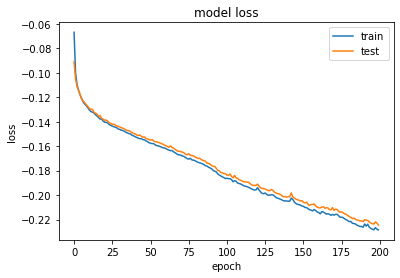

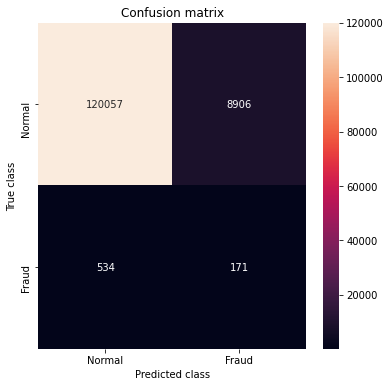

              precision    recall  f1-score   support

           0       1.00      0.93      0.96    128963
           1       0.02      0.24      0.03       705

    accuracy                           0.93    129668
   macro avg       0.51      0.59      0.50    129668
weighted avg       0.99      0.93      0.96    129668

CPU times: user 59min 52s, sys: 47min 10s, total: 1h 47min 3s
Wall time: 27min 17s


In [176]:
%%time
# building the model
input_dim = df_Train.shape[1]

encoding_dim = 14

input_layer = Input(shape=(input_dim, ))
layer1 = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer) # encoder
layer2 = Dense(int(encoding_dim / 2), activation="relu")(layer1)          # encode
layer3 = Dense(int(encoding_dim / 2), activation='tanh')(layer2)          # decoder
layer4 = Dense(input_dim, activation='relu')(layer3)                      # decoder
autoencoder = Model(inputs=input_layer, outputs=layer4)
#training the model 
nb_epoch = 200
batch_size = 1024
autoencoder.compile(optimizer='adam', 
                    #loss='mean_squared_error', 
                    loss = 'binary_crossentropy',
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h1024",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(df_Train, df_Train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(df_Test, df_Test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

# loading the saved model
autoencoder = load_model('model.h1024')


#evaluations
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');




# predictions = autoencoder.predict(df_Test)

# mse = np.mean(np.power(df_Test - predictions, 2), axis=1)
# error_df = pd.DataFrame({'reconstruction_error': mse,
#                         'true_class': Y_test})





# predictions and setting the threshold above 93 percentile
train_predicted_x = autoencoder.predict(x = df_Train)
train_events_mse = losses.mean_squared_error(df_Train,train_predicted_x)
cutoff = np.percentile(train_events_mse,93)


mse = np.mean(np.power(df_Train - train_predicted_x, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': Y_train})
error_df.describe()

# plot the confusion matrix 
LABELS = ["Normal", "Fraud"]
y_pred = [1 if e > cutoff else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

print(classification_report(error_df.true_class,y_pred))

In [ ]:
## we se that f1_score decreased.